## Image Segmentation using DPMM

Application of DPMM to Image Segmentation, here we used MCMC to approximate posterior.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.infer.mcmc import MCMC, HMC, NUTS, mcmc_kernel

from pyro.optim import Adam
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(0)

In [2]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

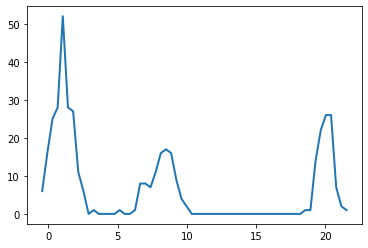

In [3]:
data = torch.cat((Normal(20, .5).sample([100]),
                  Normal(8, 1.).sample([100]),
                  Normal(1.5, .5).sample([100]),
                  Normal(0.5, .5).sample([100])))

hist, bin_edges = np.histogram(data, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, hist, lw=2)


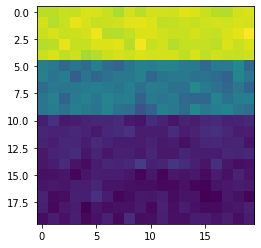

In [4]:
import random
plt.imshow(np.reshape(data, (20,20)))


In [6]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", Normal(0., 5.))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta))) 
        pyro.sample("obs", Normal(mu[z], 1.), obs=data)

    return beta,mu,z

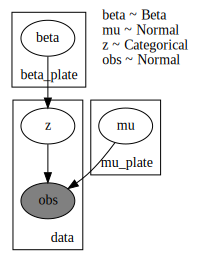

In [7]:
T = 6
N = 400
alpha = 0.05
pyro.render_model(model, model_args=(data,), render_distributions=True)

In [9]:
data = torch.reshape(torch.tensor(data), (-1,))

pyro.clear_param_store()
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, warmup_steps=300, num_samples=100, num_chains=1)
mcmc.run(data=data)
mcmc.summary()

Sample: 100%|██████████| 400/400 [03:34,  1.87it/s, step size=1.06e-01, acc. prob=0.840]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.29      0.17      0.29      0.04      0.51     10.81      1.00
   beta[1]      0.26      0.18      0.29      0.00      0.48     10.23      1.01
   beta[2]      0.50      0.03      0.50      0.45      0.56    110.46      0.99
   beta[3]      1.00      0.01      1.00      0.99      1.00     92.45      0.99
   beta[4]      0.94      0.14      1.00      0.72      1.00     82.99      1.01
     mu[0]      1.06      0.18      1.05      0.73      1.34     26.22      0.99
     mu[1]      1.31      0.74      1.10      0.57      2.25     14.73      1.06
     mu[2]      8.16      0.10      8.16      7.97      8.29     68.02      1.04
     mu[3]     20.01      0.12     20.02     19.75     20.17     75.64      0.99
     mu[4]      0.52      5.11      0.77     -6.73      9.68     66.79      0.99
     mu[5]      0.53      4.76      0.92     -7.57      7.36     94.90      1.01

Number of divergences: 0


In [10]:
mcmc_samples = mcmc.get_samples(group_by_chain=True)

beta = mcmc_samples['beta'][0]
mu = mcmc_samples['mu'][0]

torch.Size([1, 100, 6])


<AxesSubplot:ylabel='Density'>

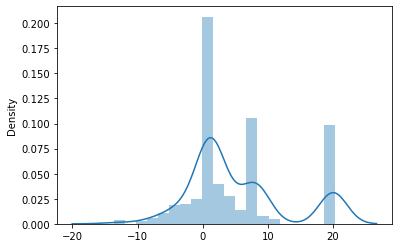

In [11]:
import seaborn as sns

print(mcmc_samples['mu'].shape)
sns.distplot(mcmc_samples["mu"])

In [13]:
from scipy.stats import norm 

mu = mu[-10:]
beta = beta[-10:]

n_samples = mu.shape[0]
n = data.shape[0]
cluster = np.zeros(n)

for i in range(n):
    q = torch.zeros(T)
    for j in range(T):
        for k in range(n_samples):
            q[j] = norm.pdf(data[i], mu[k,j], 1.) + q[j]

    cluster[i] = np.argmax(q)

Assign clusters:

In [15]:
from scipy.stats import norm 

w = mix_weights(beta)[-1]
n_samples = mu.shape[0]
n = data.shape[0]
cluster = np.zeros(n)

for i in range(n):
    q = torch.zeros(T)
    for j in range(T):
        q[j] = w[j]*norm.pdf(data[i], mu[-1][j], 1.) + q[j]

    cluster[i] = np.argmax(q)

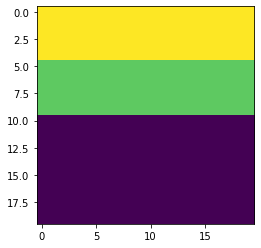

In [29]:
plt.imshow( np.reshape(cluster, (20,20)))
